In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics

In [2]:
data= pd.read_csv(r"C:\Users\alexm\TFG_09_05\balanced_dataset_total.csv", sep=',', low_memory=False)
data.shape

(102056, 90)

In [3]:
data['bytecount'] = data['Total Length of Fwd Packets'] + data[' Total Length of Bwd Packets']
data['packetins'] = data[' Total Fwd Packets'] + data[' Total Backward Packets']
data.shape

(102056, 92)

In [4]:
numeric_df = data.select_dtypes(include=['int64', 'float64'])
object_df = data.select_dtypes(include=['object'])
numeric_cols = numeric_df.columns
object_cols = object_df.columns
print('Numeric Columns: ')
print(numeric_cols, '\n')
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Numeric Features: ', len(numeric_cols))
print('Number of Object Features: ', len(object_cols))

Numeric Columns: 
Index(['Unnamed: 0', ' Source Port', ' Destination Port', ' Protocol',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Max', ' Fwd IAT Min',
       'Bwd IAT Total', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', ' Min Packet Length',
       ' Max Packet Length', 'FIN Flag Count', ' SYN Flag Count',
       ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
       ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count',
       ' Down/Up Ratio', ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
       ' Bw

In [5]:
data[' Packet Length Mean'] = pd.to_numeric(data[' Packet Length Mean'], errors='coerce')
data['Flow Bytes/s'] = pd.to_numeric(data['Flow Bytes/s'], errors='coerce')
data[' Flow Packets/s'] = pd.to_numeric(data[' Flow Packets/s'], errors='coerce')
data[' Average Packet Size'] = pd.to_numeric(data[' Average Packet Size'], errors='coerce')

In [6]:
balanced_data = data

In [7]:
class Model:
    global y

    def __init__(self, balanced_data):
        self.data = balanced_data
        X = preprocessing.StandardScaler().fit(self.data).transform(self.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=42, test_size=0.3)
        self.accuracy_rf = 0
        self.best_rf = None  # Para almacenar el mejor modelo

    def RandomForest(self):
        start_time = time.time()

        param_grid = {
            'n_estimators': [100, 200, 500],
            'min_samples_split': [2, 5, 10],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [None, 3, 4, 5, 6]
        }

        rf_base = RandomForestClassifier(
            criterion='gini',
            oob_score=True,
            random_state=1,
            n_jobs=-1
        )

        rf_search = GridSearchCV(rf_base, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
        rf_search.fit(self.X_train, self.y_train)

        self.best_rf = rf_search.best_estimator_
        predicted_rf = self.best_rf.predict(self.X_test)
        accuracy_rf = accuracy_score(self.y_test, predicted_rf)

        print(f"Accuracy of RF model is: {round(accuracy_rf * 100, 2)}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_rf, self.y_test))
        print("########################################################################")
        print("--- %s seconds ---" % (time.time() - start_time))

        self.accuracy_rf = accuracy_rf

    def run_models(self):
        self.RandomForest()

        model_name = ['Random Forest']
        accuracies = [self.accuracy_rf * 100]

        self.plot_accuracy(accuracies, model_name)

    def plot_accuracy(self, accuracies, model_names):
        plt.figure(figsize=(6, 4))
        plt.bar(model_names, accuracies, color='green')
        plt.xlabel('Model')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy')
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.show()
        
    def plot_single_tree(self, tree_index=0):
        if self.best_rf is None:
            print("Random Forest model not trained yet.")
            return

        estimator = self.best_rf.estimators_[tree_index]
        feature_names = self.data.columns

        plt.figure(figsize=(20,10))
        plot_tree(estimator, 
                  feature_names=feature_names, 
                  class_names=[str(cls) for cls in set(self.y_train)],
                  filled=True,
                  rounded=True,
                  fontsize=10)
        plt.show()

In [8]:
balanced_data_df = balanced_data.copy()
balanced_data_df = balanced_data_df.dropna()


In [9]:
balanced_data_df = balanced_data_df.replace([np.inf, -np.inf], np.nan)  # Reemplazar infinitos con NaN
balanced_data_df = balanced_data_df.dropna() 
balanced_data_df = balanced_data_df.rename(columns={
    ' Flow Duration': 'dur',
    ' Packet Length Mean': 'pktperflow',
    ' Average Packet Size': 'byteperflow',
    ' Flow Packets/s': 'pktrate',
    'Total Length of Fwd Packets': 'tx_bytes',
    ' Total Length of Bwd Packets': 'rx_bytes',
    'Flow Bytes/s': 'tot_kbps',
    'pairflow': 'Pairflow'
})
columns_to_keep = ['bytecount','dur','packetins','pktperflow','byteperflow','pktrate','Pairflow','tx_bytes','rx_bytes','tot_kbps']
#columns_to_keep = [' Flow Duration',' Total Fwd Packets',' Total Backward Packets','Total Length of Fwd Packets',' Total Length of Bwd Packets',' Fwd Packet Length Mean',' Bwd Packet Length Mean',' Packet Length Mean',' Average Packet Size','Flow Bytes/s',' Flow Packets/s','Fwd Packets/s',' Bwd Packets/s']
X = balanced_data_df.filter(items=columns_to_keep)
#X = balanced_data_df.replace([np.inf, -np.inf], np.nan)  # Reemplazar infinitos con NaN
#X = X.dropna() 
y = balanced_data_df.etiqueta

In [10]:
X.shape

(99286, 10)

In [11]:
X

,bytecount,dur,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tot_kbps
0,278.0,20697,4,63.4,79.250000,1.932647e+02,1,78.0,200.0,1.343190e+04
1,864.0,1,2,432.0,648.000000,2.000000e+06,0,864.0,0.0,8.640000e+08
2,160.0,20585,4,38.4,48.000000,1.943162e+02,1,64.0,96.0,7.772650e+03
3,1136.0,1,2,568.0,852.000000,2.000000e+06,0,1136.0,0.0,1.136000e+09
4,1192.0,1,2,596.0,894.000000,2.000000e+06,0,1192.0,0.0,1.192000e+09
...,...,...,...,...,...,...,...,...,...,...
102051,0.0,55433,4,0.0,0.000000,7.215918e+01,1,0.0,0.0,0.000000e+00
102052,268.0,20687,4,61.4,76.750000,1.933581e+02,1,78.0,190.0,1.295500e+04
102053,7224.0,18001537,14,516.0,552.857143,7.777114e-01,0,7224.0,0.0,4.012991e+02
102054,0.0,3,2,0.0,0.000000,6.666667e+05,0,0.0,0.0,0.000000e+00


In [12]:
numeric_df = X.select_dtypes(include=['int64', 'float64'])
object_df = X.select_dtypes(include=['object'])
numeric_cols = numeric_df.columns
object_cols = object_df.columns
print('Numeric Columns: ')
print(numeric_cols, '\n')
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Numeric Features: ', len(numeric_cols))
print('Number of Object Features: ', len(object_cols))

Numeric Columns: 
Index(['bytecount', 'dur', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow', 'tx_bytes', 'rx_bytes', 'tot_kbps'],
      dtype='object') 

Object Columns: 
Index([], dtype='object') 

Number of Numeric Features:  10
Number of Object Features:  0


In [13]:
y.shape

(99286,)

In [14]:
X = pd.get_dummies(X)

In [15]:
M = Model(X)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Accuracy of RF model is: 99.6% 

########################################################################
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14835
           1       1.00      0.99      1.00     14951

    accuracy                           1.00     29786
   macro avg       1.00      1.00      1.00     29786
weighted avg       1.00      1.00      1.00     29786

########################################################################
--- 850.2396845817566 seconds ---


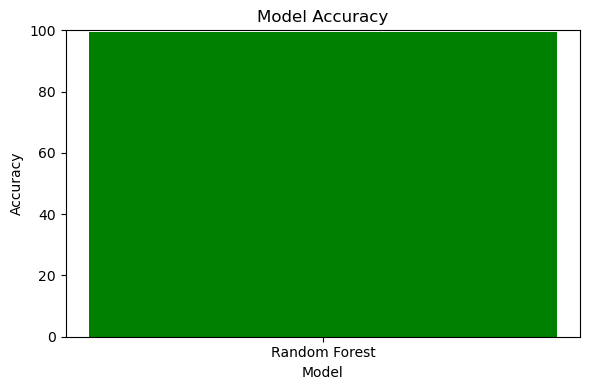

In [16]:
M.run_models()

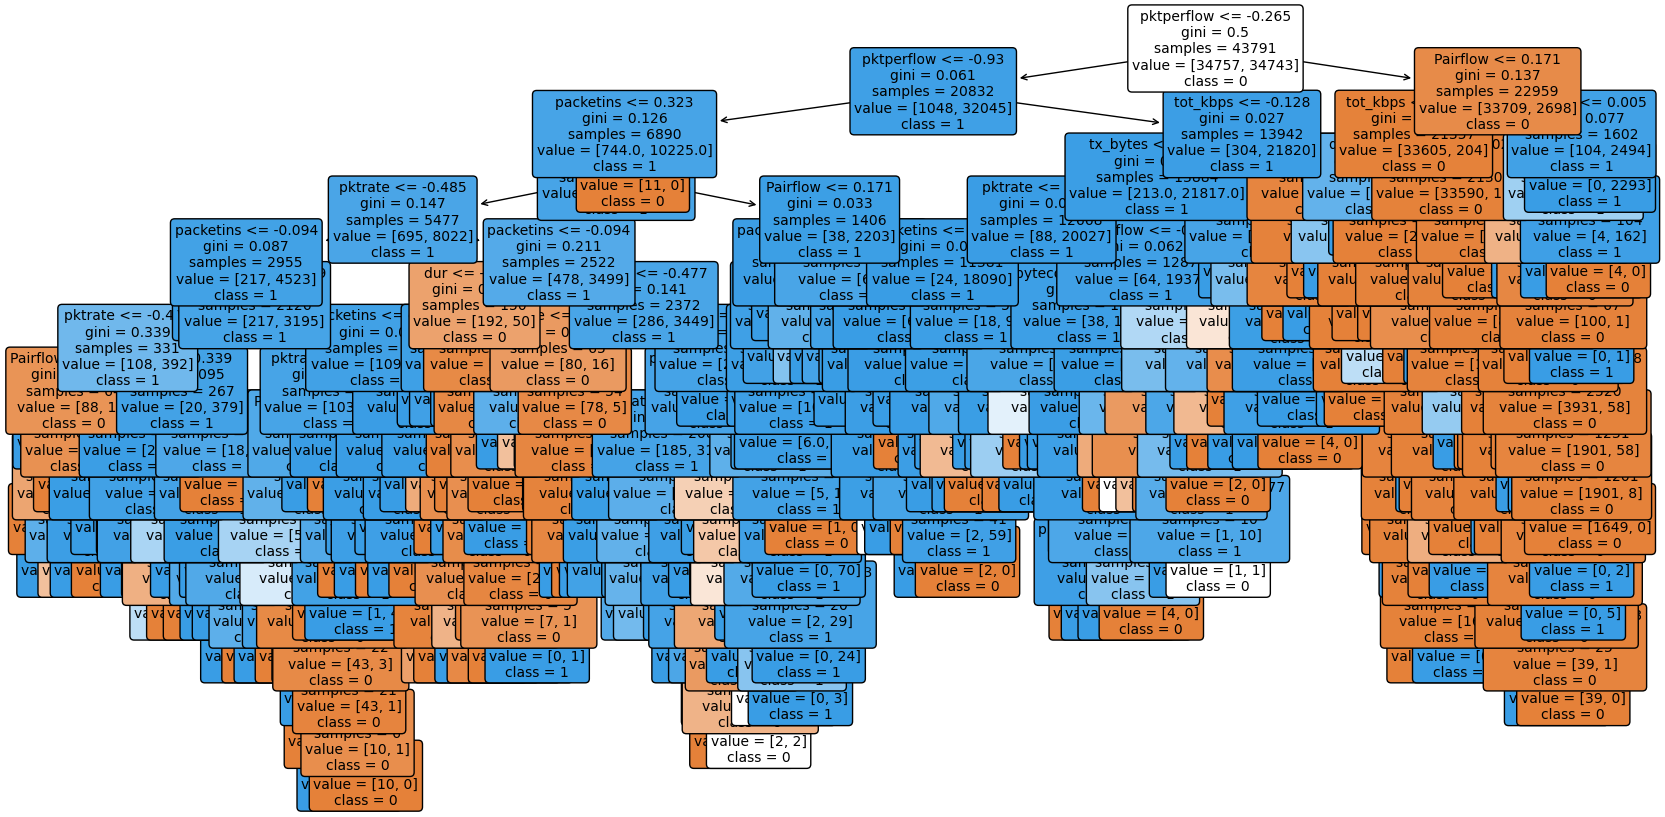

In [17]:
M.plot_single_tree(tree_index=0)